In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from morphology_augmentation import calculate_black_ratio, process_image, crop_center

def run_quick_test():
    """
    A quick test function to demonstrate the image augmentation algorithm
    with a sample image from the repository.
    
    This test:
    1. Loads a sample image
    2. Processes it with a target ratio
    3. Displays and saves the original and processed images
    4. Reports the black/white pixel ratios
    """
    print("Running quick test for subsurface image augmentation...")
    
    # Assume sample folder contains example images
    sample_folder = "Original1115"
    test_image_path = os.path.join(sample_folder, "GI1.PNG")
    
    # Create output folder if it doesn't exist
    test_output_folder = "test_output"
    if not os.path.exists(test_output_folder):
        os.makedirs(test_output_folder)
    
    # Load the image
    print(f"Loading image from: {test_image_path}")
    image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"ERROR: Failed to load test image from {test_image_path}")
        print("Please ensure the sample_images folder contains GI1.PNG")
        return False
    
    # Calculate original black pixel ratio
    original_ratio = calculate_black_ratio(image)
    print(f"Original image black pixel ratio: {original_ratio:.3f}")
    
    # Set target ratio for test (10% higher than original)
    target_ratio = min(0.9, original_ratio * 1.1)
    print(f"Target black pixel ratio: {target_ratio:.3f}")
    
    # Process the image
    processed, final_ratio, operations = process_image(image, target_ratio)
    print(f"Final black pixel ratio: {final_ratio:.3f}")
    print(f"Operations performed: {len(operations)}")
    
    # Crop processed image
    crop_size = 230
    processed_cropped = crop_center(processed, crop_size)
    cropped_ratio = calculate_black_ratio(processed_cropped)
    print(f"Cropped image black pixel ratio: {cropped_ratio:.3f}")
    
    # Save test results
    cv2.imwrite(os.path.join(test_output_folder, "original.png"), image)
    cv2.imwrite(os.path.join(test_output_folder, "processed.png"), processed)
    cv2.imwrite(os.path.join(test_output_folder, "processed_cropped.png"), processed_cropped)
    
    # Create visualization with matplotlib
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original (Ratio: {original_ratio:.3f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(processed, cmap='gray')
    plt.title(f"Processed (Ratio: {final_ratio:.3f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(processed_cropped, cmap='gray')
    plt.title(f"Cropped (Ratio: {cropped_ratio:.3f})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(test_output_folder, "test_results.png"))
    
    # Check if test was successful
    success = abs(final_ratio - target_ratio) < 0.05
    message = "TEST PASSED" if success else "TEST NEEDS REVIEW"
    print(f"\n{message}: Final ratio {final_ratio:.3f} vs target {target_ratio:.3f}")
    
    print(f"\nTest images saved to {test_output_folder} folder")
    return success

if __name__ == "__main__":
    run_quick_test()

ModuleNotFoundError: No module named 'morphology_augmentation'

Running quick test for subsurface image augmentation...
Loading image from: Original1115/GI1.PNG
Original image black pixel ratio: 0.580
Target black pixel ratio: 0.639
Final black pixel ratio: 0.634
Operations performed: 218
Cropped image black pixel ratio: 0.637

TEST PASSED: Final ratio 0.634 vs target 0.639

Test images saved to test_output folder


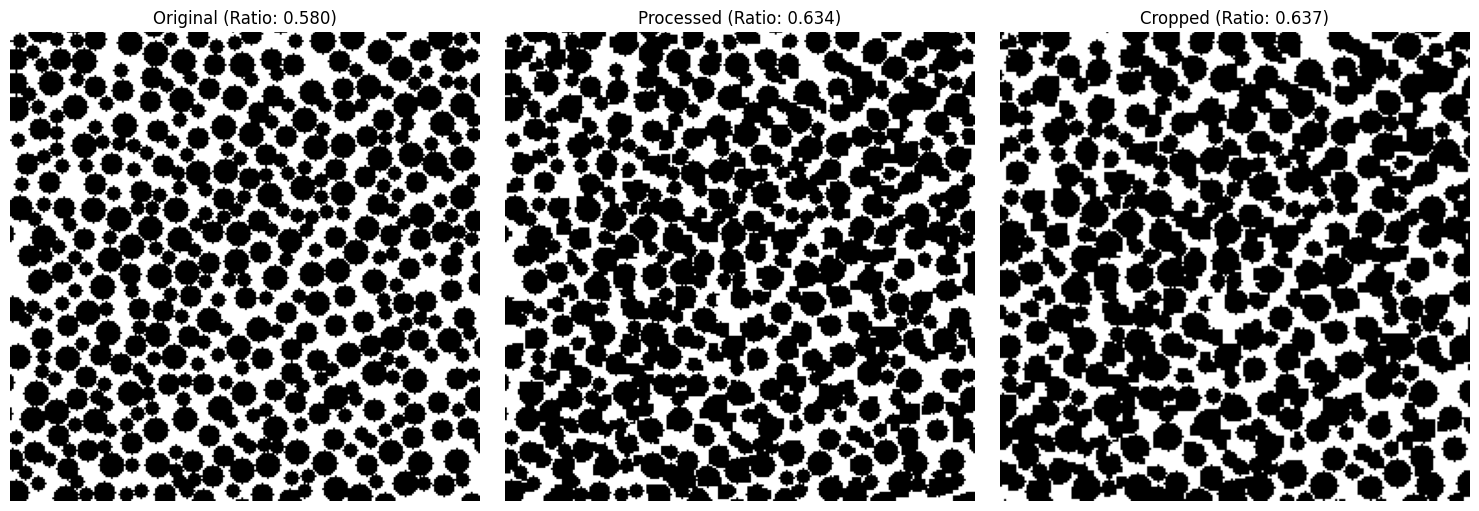

In [6]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import sys

script_filename = "main" 

try:
    module = __import__(script_filename)
    calculate_black_ratio = module.calculate_black_ratio
    process_image = module.process_image
    crop_center = module.crop_center
except ImportError:
    def crop_center(img, crop_size):
        """
        Crop the center portion of an image to the specified size.
        
        Args:
            img: Input image
            crop_size: Size of the square crop
            
        Returns:
            Cropped image
        """
        height, width = img.shape[:2]
        start_x = (width - crop_size) // 2
        start_y = (height - crop_size) // 2
        return img[start_y:start_y+crop_size, start_x:start_x+crop_size]

    def calculate_black_ratio(img):
        """
        Calculate the proportion of black pixels in the image.
        
        Args:
            img: Binary image (255 for white, 0 for black)
            
        Returns:
            Ratio of black pixels to total pixels
        """
        return 1 - np.sum(img == 255) / img.size

    def calculate_black_pixels(img):
        """
        Count the number of black pixels in the image.
        
        Args:
            img: Binary image (255 for white, 0 for black)
            
        Returns:
            Number of black pixels
        """
        return np.sum(img != 255)

    def get_multiple_random_positions(img, target_type, num_points):
        """
        Get multiple random pixel positions of the specified type.
        
        Args:
            img: Binary image
            target_type: 'black' or 'white', the type of pixels to select
            num_points: Number of points to return
            
        Returns:
            List of (y, x) coordinate tuples
        """
        height, width = img.shape
        target_value = 0 if target_type == 'black' else 255
        positions = np.where(img == target_value)
        
        if len(positions[0]) == 0:
            return []
        
        # Ensure we don't request more points than available
        num_points = min(num_points, len(positions[0]))
        indices = random.sample(range(len(positions[0])), num_points)
        return [(positions[0][i], positions[1][i]) for i in indices]

    def apply_local_morphology(img, center_position, operation, kernel_size=3):
        """
        Apply a morphological operation locally around a specific position.
        
        Args:
            img: Input binary image
            center_position: (y, x) coordinate for the center of operation
            operation: Type of morphology ('erosion', 'dilation', 'opening', 'closing')
            kernel_size: Size of the square kernel for the operation
            
        Returns:
            Processed image with local morphology applied
        """
        height, width = img.shape
        y, x = center_position
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        
        # Ensure region stays within image boundaries
        y_start = max(0, y - kernel_size//2)
        y_end = min(height, y + kernel_size//2 + 1)
        x_start = max(0, x - kernel_size//2)
        x_end = min(width, x + kernel_size//2 + 1)
        
        temp_img = img.copy()
        region = temp_img[y_start:y_end, x_start:x_end]
        
        # Apply appropriate morphological operation
        if operation == 'erosion':
            processed_region = cv2.erode(region, kernel[:y_end-y_start, :x_end-x_start])
        elif operation == 'dilation':
            processed_region = cv2.dilate(region, kernel[:y_end-y_start, :x_end-x_start])
        elif operation == 'opening':
            processed_region = cv2.morphologyEx(region, cv2.MORPH_OPEN, kernel[:y_end-y_start, :x_end-x_start])
        else:  # closing
            processed_region = cv2.morphologyEx(region, cv2.MORPH_CLOSE, kernel[:y_end-y_start, :x_end-x_start])
        
        # Replace the region in the original image
        temp_img[y_start:y_end, x_start:x_end] = processed_region
        return temp_img

    def process_image(img, target_ratio):
        """
        Process an image to achieve a target black/white ratio using improved strategies.
        
        Args:
            img: Input grayscale image
            target_ratio: Target ratio of black pixels to total pixels
            
        Returns:
            Tuple of (processed image, final ratio, list of operations used)
        """
        # Convert to binary image
        _, binary = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
        
        # Calculate target number of black pixels
        total_pixels = binary.size
        target_black_pixels = int(target_ratio * total_pixels)
        
        # Initialize output image
        processed = binary.copy()
        operations_used = []
        max_iterations = 300
        
        # Parameters for adaptive processing
        min_points = 2
        max_points = 15
        
        for iteration in range(max_iterations):
            # Check current state
            current_black_pixels = calculate_black_pixels(processed)
            pixel_diff = abs(current_black_pixels - target_black_pixels)
            
            # Dynamically adjust parameters based on how far we are from the target
            if pixel_diff > 1000:
                tolerance = 10
                points_range = (8, max_points)
                kernel_size = 5
            elif pixel_diff > 500:
                tolerance = 8
                points_range = (5, 12)
                kernel_size = 3
            elif pixel_diff > 100:
                tolerance = 5
                points_range = (3, 8)
                kernel_size = 3
            else:
                tolerance = 3
                points_range = (min_points, 5)
                kernel_size = 3
            
            # If we're close enough to the target, stop processing
            if pixel_diff <= tolerance:
                break
            
            # Determine number of points to modify in this iteration
            points_per_iteration = random.randint(*points_range)
            
            # Choose operation type based on current state vs target
            if current_black_pixels < target_black_pixels:
                # Need more black pixels - use erosion or closing
                pixel_positions = get_multiple_random_positions(processed, 'black', points_per_iteration)
                if pixel_diff > 500:
                    # Far from target: prefer erosion (7:3 ratio)
                    operation = random.choice(['erosion'] * 7 + ['closing'] * 3)
                else:
                    # Close to target: use more balanced approach
                    operation = random.choice(['erosion'] * 5 + ['closing'] * 5)
            else:
                # Need fewer black pixels - use dilation or opening
                pixel_positions = get_multiple_random_positions(processed, 'white', points_per_iteration)
                if pixel_diff > 500:
                    # Far from target: prefer dilation (7:3 ratio)
                    operation = random.choice(['dilation'] * 7 + ['opening'] * 3)
                else:
                    # Close to target: use more balanced approach
                    operation = random.choice(['dilation'] * 5 + ['opening'] * 5)
            
            # If no suitable positions found, exit loop
            if not pixel_positions:
                break
            
            # Decide whether to use same operation for all points (70% chance)
            use_same_operation = random.random() < 0.7
            
            # Apply morphological operations to selected points
            temp_img = processed.copy()
            for pos in pixel_positions:
                if not use_same_operation:
                    # Randomize operation for each point if not using same operation
                    if current_black_pixels < target_black_pixels:
                        operation = random.choice(['erosion', 'closing'])
                    else:
                        operation = random.choice(['dilation', 'opening'])
                temp_img = apply_local_morphology(temp_img, pos, operation, kernel_size)
            
            # Check if new image is closer to target
            new_black_pixels = calculate_black_pixels(temp_img)
            new_diff = abs(new_black_pixels - target_black_pixels)
            
            # Accept new image if it's better or slightly worse but random chance allows it
            if new_diff < pixel_diff or (new_diff < pixel_diff * 1.1 and random.random() < 0.3):
                processed = temp_img
                operations_used.append(operation)
        
        # Calculate final black ratio
        current_ratio = calculate_black_ratio(processed)
        return processed, current_ratio, operations_used

import random

def run_quick_test():
    """
    A quick test function to demonstrate the image augmentation algorithm
    with a sample image from the repository.
    
    This test:
    1. Loads a sample image
    2. Processes it with a target ratio
    3. Displays and saves the original and processed images
    4. Reports the black/white pixel ratios
    """
    print("Running quick test for subsurface image augmentation...")
    
    # Assume sample folder contains example images
    sample_folder = "Original1115"
    test_image_path = os.path.join(sample_folder, "GI1.PNG")
    
    # Create output folder if it doesn't exist
    test_output_folder = "test_output"
    if not os.path.exists(test_output_folder):
        os.makedirs(test_output_folder)
    
    # Load the image
    print(f"Loading image from: {test_image_path}")
    image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        print(f"ERROR: Failed to load test image from {test_image_path}")
        print("Please ensure the sample_images folder contains GI1.PNG")
        return False
    
    # Calculate original black pixel ratio
    original_ratio = calculate_black_ratio(image)
    print(f"Original image black pixel ratio: {original_ratio:.3f}")
    
    # Set target ratio for test (10% higher than original)
    target_ratio = min(0.9, original_ratio * 1.1)
    print(f"Target black pixel ratio: {target_ratio:.3f}")
    
    # Process the image
    processed, final_ratio, operations = process_image(image, target_ratio)
    print(f"Final black pixel ratio: {final_ratio:.3f}")
    print(f"Operations performed: {len(operations)}")
    
    # Crop processed image
    crop_size = 230
    processed_cropped = crop_center(processed, crop_size)
    cropped_ratio = calculate_black_ratio(processed_cropped)
    print(f"Cropped image black pixel ratio: {cropped_ratio:.3f}")
    
    # Save test results
    cv2.imwrite(os.path.join(test_output_folder, "original.png"), image)
    cv2.imwrite(os.path.join(test_output_folder, "processed.png"), processed)
    cv2.imwrite(os.path.join(test_output_folder, "processed_cropped.png"), processed_cropped)
    
    # Create visualization with matplotlib
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Original (Ratio: {original_ratio:.3f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(processed, cmap='gray')
    plt.title(f"Processed (Ratio: {final_ratio:.3f})")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(processed_cropped, cmap='gray')
    plt.title(f"Cropped (Ratio: {cropped_ratio:.3f})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(test_output_folder, "test_results.png"))
    
    # Check if test was successful
    success = abs(final_ratio - target_ratio) < 0.05
    message = "TEST PASSED" if success else "TEST NEEDS REVIEW"
    print(f"\n{message}: Final ratio {final_ratio:.3f} vs target {target_ratio:.3f}")
    
    print(f"\nTest images saved to {test_output_folder} folder")
    return success

if __name__ == "__main__":
    run_quick_test()